In [1]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
from ccode.modified_boundstate import modified_find_boundstates
from ccode.boundstate import find_boundstates, extract_boundstates
import scipy.sparse.linalg as sla
import time

%matplotlib inline
plt.rcParams.update({"font.size": 12})

# Minimal example of bound state algorithm

All comments are refering to wires of width 3, but discussion holds for thicker wires.

Modifications of the original algorithm:
* Interval of energies is sorted such that is starts looking around zero energy.
* Search of energy candidates stops after having two candidates.

Other modifications are just printing times

#### Helper functions

In [2]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T

In [3]:
cavity_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu_cavity) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + B_x * kron(sigma_x, sigma_0)
"""

cavity_template = kwant.continuum.discretize(cavity_hamiltonian)

/tmp/ipykernel_2560/1296386344.py:8: KwantDeprecationWarning: Accessing kwant.continuum without an explicit import is deprecated. Instead, explicitly 'import kwant.continuum'.
  cavity_template = kwant.continuum.discretize(cavity_hamiltonian)
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [4]:
lead_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""

a = 1
lead_template = kwant.continuum.discretize(lead_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [5]:
# Hamiltonian of the system
finite_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu(x,y)) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    - alpha * k_y * kron(sigma_x, sigma_z)
    + Delta(x,y) * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""
finite_template = kwant.continuum.discretize(finite_hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [6]:
def circle_shape(r):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2
    return shape


def make_circular_cavity(r):
    junction = kwant.Builder()
    junction.fill(
        cavity_template,
        shape=circle_shape(r),
        start=[0,0]
    )
    return junction

In [7]:
def circle_junction_shape(r, l, w):
    def shape(site):
        x, y = site.pos
        return x**2 + y**2 < r**2 or (np.abs(x) < l + r and np.abs(y) < w/2)
    return shape


def make_circular_junction(r, l, w):
    junction = kwant.Builder()
    junction.fill(
        finite_template,
        shape=circle_junction_shape(r, l, w),
        start=[0, 0]
    )
    return junction.finalized()


def shape_wires_circle(r, mu_circle, mu_wires):
    def shape(x, y):
        if x**2 + y**2 < r**2:
            return mu_circle
        else:
            return mu_wires
    return shape


def f_params_circular_junction(r, **parameters):
    #print(parameters)
    params = parameters.copy()
    mu_circle = params.pop('mu_cavity')
    mu_wires = params.pop('mu_wires')
    Delta = params['Delta']

    params.update(mu=shape_wires_circle(r=r,
                                        mu_circle=mu_circle,
                                        mu_wires=mu_wires))
    params.update(Delta=shape_wires_circle(r=r,
                                        mu_circle=0,
                                        mu_wires=Delta))


    return params

## Circular junction

### Bound state algorithm

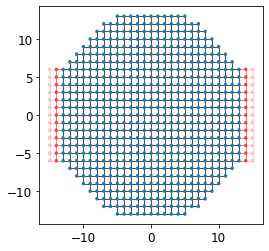

In [53]:
# create system
circle = make_circular_cavity(r=14)
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
W = 13
# lead position
x0 = -9
y0 = 0
lead.fill(lead_template,
          shape=lambda site: -W/2 + y0 <= site.pos[1] < W/2 + y0,
          start=[x0, y0]);
circle.attach_lead(lead)
circle.attach_lead(lead.reversed())
circle = circle.finalized()
fig, ax = plt.subplots(figsize=(4, 4))
kwant.plot(circle, ax=ax);

In [54]:
# parameters such that MBS will be coupled
# the topological gap at B = 0.5 is gap* = 0.05
# therefore min_energy = -gap* and max_energy = gap*
params = {
    't': 1,
    'mu': 0.3,
    'mu_cavity': 0.4,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [55]:
%%time
# execution of modified bs algorithm
# extracted energy and computation time depend strongly on rtol
# rtol = 1e-2; time = 2.05 s; energy = 0.026
# rtol = 1e-3; time = 4.27 s; energy = 0.008
# rtol = 1e-4; time = 26.4 s; energy = 0.006
en, vec = modified_find_boundstates(syst=circle,
                           min_energy=-0.05,
                           max_energy=0.05,
                           sparse=True,
                           params=params,
                           rtol= 1e-3
                          )

Time evaluate bound state condition: 0.32141566276550293
Time evaluate bound state condition: 0.28925180435180664
Time find bound state energy: 0.5347554683685303
Time evaluate bound state condition: 0.2553436756134033
Time evaluate bound state condition: 0.2555844783782959
Time evaluate bound state condition: 0.27544283866882324
Time evaluate bound state condition: 0.27613186836242676
Time evaluate bound state condition: 0.29556894302368164
Time evaluate bound state condition: 0.28240060806274414
Time evaluate bound state condition: 0.299314022064209
Time evaluate bound state condition: 0.30629539489746094
Time evaluate bound state condition: 0.28134751319885254
Time evaluate bound state condition: 0.30461978912353516
Time evaluate bound state condition: 0.28324007987976074
Time evaluate bound state condition: 0.2479724884033203
Time evaluate bound state condition: 0.24640870094299316
Time evaluate bound state condition: 0.2495107650756836
Time evaluate bound state condition: 0.250516

In [56]:
en

array([0.01022632])

In [58]:
%%time
# execution of original bs algorithm
# lowest extracted bound state is the same as the previous case
# but computation takes much longer due to consideration of all candidates
# rtol = 1e-2; time = 14 s
# energies = 0.02658972,  0.04001602
# rtol = 1e-3; time = 51.3 s
# energies = 0.00856191,  0.01915394,  0.02551161,  0.04001602,  0.04723886
# rtol = 1e-4; time = 3 min 38 s
# energies = 0.00657352,  0.00856191,  0.01915394, 0.02551161,  0.02658972,  0.04001602,  0.04723886
en, vec = find_boundstates(syst=circle,
                           min_energy=-0.05,
                           max_energy=0.05,
                           sparse=True,
                           params=params,
                           rtol=1e-3
                          )

Time evaluate bound state condition: 0.33208799362182617
Time find bound state energy: 0.8359463214874268
Time evaluate bound state condition: 0.256331205368042
Time evaluate bound state condition: 0.2777135372161865
Time evaluate bound state condition: 0.3023056983947754
Time evaluate bound state condition: 0.3017141819000244
Time evaluate bound state condition: 0.30239105224609375
Time evaluate bound state condition: 0.3039436340332031
Time evaluate bound state condition: 0.30825376510620117
Time find bound state energy: 4.840905666351318
Time evaluate bound state condition: 0.3036234378814697
Time evaluate bound state condition: 0.28163838386535645
Time evaluate bound state condition: 0.2599217891693115
Time evaluate bound state condition: 0.25751256942749023
Time find bound state energy: 0.8807618618011475
Time evaluate bound state condition: 0.2513539791107178
Time evaluate bound state condition: 0.2456068992614746
Time evaluate bound state condition: 0.24423933029174805
Time find

In [59]:
en

array([-0.03162861, -0.02876076, -0.01568878, -0.01022632,  0.01022632,
        0.01568878,  0.02876076,  0.03162861])

### Sparse diagonalization

(-16.0, 16.0)

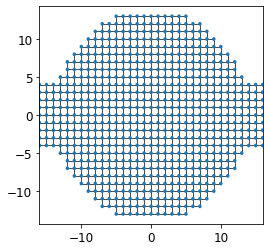

In [76]:
circle_junction = make_circular_junction(r=14, l=200, w=9)
fig, ax = plt.subplots(figsize=(4, 4))
kwant.plot(circle_junction, ax=ax);
ax.set_xlim(-16, 16)

In [77]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': 0.4,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [78]:
%%time
# sparse diagonalization finds all bound states in 601 ms
# energies = 6.57e-03, 8.56e-03,  1.91e-02,  2.55e-02,  2.65e-02, 4.00e-02,  4.72e-02
# lowest state found in 200 ms
ham = circle_junction.hamiltonian_submatrix(sparse=True,
                                            params=f_params_circular_junction(r=14, **params))
val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=4, sigma=0))

CPU times: user 1.33 s, sys: 27.9 ms, total: 1.36 s
Wall time: 1.36 s


In [79]:
val

array([-0.02084086, -0.0094878 ,  0.0094878 ,  0.02084086])

In [66]:
# we conclude that sparse diagonalization is faster than the current bs algorithm
# times shown are for wires of width = 3, but general behaviour holds for thicker systems
# for example, for wires width = 9:
# sparse time = 1.19 s vs modified bs time = 6.9 s vs full bs = 8.41 with rtol = 1e-2
# for wires width = 13
# sparse time = 920 ms vs modified bs time = 6.82 s vs full bs time = 1 min 18 s with rtol = 1e-3
# rtol chosen s.t. lowest state is found
# if not small enough, bs algorithm finds second bound state

In [71]:
# sanity check, look for majoranas by depleting the cavity

In [68]:
params = {
    't': 1,
    'mu_wires': 0.3,
    'mu_cavity': -2,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [69]:
%%time
# sparse diagonalization finds all bound states in 601 ms
# energies = 6.57e-03, 8.56e-03,  1.91e-02,  2.55e-02,  2.65e-02, 4.00e-02,  4.72e-02
# lowest state found in 200 ms
ham = circle_junction.hamiltonian_submatrix(sparse=True,
                                            params=f_params_circular_junction(r=14, **params))
val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=4, sigma=0))

CPU times: user 726 ms, sys: 23 ms, total: 749 ms
Wall time: 746 ms


In [70]:
val

array([-1.24413999e-09, -1.24413945e-09,  1.24413952e-09,  1.24414005e-09])

In [72]:
density = kwant.operator.Density(circle_junction, np.eye(4))

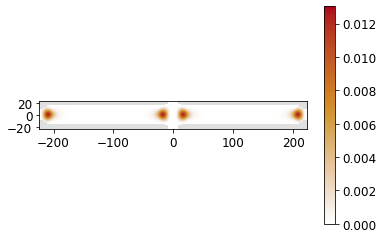

/tmp/ipykernel_2560/1720318116.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(circle_junction, density(vec[1]));


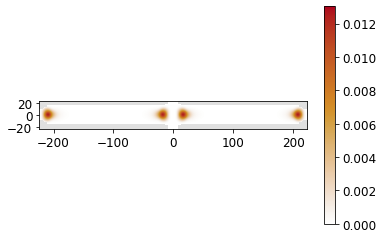

/tmp/ipykernel_2560/1720318116.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(circle_junction, density(vec[2]));


In [75]:
kwant.plotter.density(circle_junction, density(vec[1]));
kwant.plotter.density(circle_junction, density(vec[2]));